In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 0.75, 11))
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [4]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, SpectralMixtureKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [9]:
class SpectralMixtureGPModel(gpytorch.GPModel):
    def __init__(self):
        super(SpectralMixtureGPModel,self).__init__(GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = SpectralMixtureKernel()
        self.register_parameter('log_noise', nn.Parameter(torch.Tensor([-2])), bounds=(-5, 5))
        self.register_parameter('log_mixture_weights', nn.Parameter(torch.zeros(3)), bounds=(-5, 5))
        self.register_parameter('log_mixture_means', nn.Parameter(torch.zeros(3)), bounds=(-5, 5))
        self.register_parameter('log_mixture_scales', nn.Parameter(torch.zeros(3)), bounds=(-5, 5))

    def forward(self,x):
        mean_x = self.mean_module(x, constant=Variable(torch.Tensor([0])))
        covar_x = self.covar_module(x,
                                    log_mixture_weights=self.log_mixture_weights,
                                    log_mixture_means=self.log_mixture_means,
                                    log_mixture_scales=self.log_mixture_scales)

        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred, self.log_noise

prior_model = SpectralMixtureGPModel()

In [26]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 5, 51))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

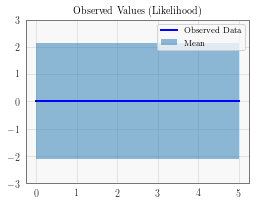

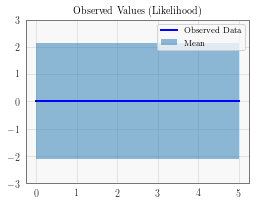

In [27]:
plot_model_and_predictions(prior_model, plot_train_data=False)

In [28]:
from gpytorch.inference import Inference
infer = Inference(prior_model)
posterior_model = infer.run(train_x, train_y)

# Find optimal model hyperparameters
posterior_model.train()
optimizer = optim.Adam(posterior_model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(50):
    optimizer.zero_grad()
    output = posterior_model(train_x)
    loss = -posterior_model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()
    
# Set back to eval mode
posterior_model.eval()
None

Iter 1/50 - Loss: 11.869
Iter 2/50 - Loss: 9.429
Iter 3/50 - Loss: 8.154
Iter 4/50 - Loss: 5.786
Iter 5/50 - Loss: 7.568
Iter 6/50 - Loss: 7.656
Iter 7/50 - Loss: 5.985
Iter 8/50 - Loss: 6.732
Iter 9/50 - Loss: 7.658
Iter 10/50 - Loss: 4.695
Iter 11/50 - Loss: 7.016
Iter 12/50 - Loss: 5.961
Iter 13/50 - Loss: 5.887
Iter 14/50 - Loss: 5.742
Iter 15/50 - Loss: 6.133
Iter 16/50 - Loss: 5.072
Iter 17/50 - Loss: 4.698
Iter 18/50 - Loss: 5.211
Iter 19/50 - Loss: 4.656
Iter 20/50 - Loss: 5.105
Iter 21/50 - Loss: 5.759
Iter 22/50 - Loss: 6.603
Iter 23/50 - Loss: 4.248
Iter 24/50 - Loss: 3.229
Iter 25/50 - Loss: 4.974
Iter 26/50 - Loss: 4.344
Iter 27/50 - Loss: 2.501
Iter 28/50 - Loss: 2.533
Iter 29/50 - Loss: 2.776
Iter 30/50 - Loss: 3.647
Iter 31/50 - Loss: 3.349
Iter 32/50 - Loss: 4.239
Iter 33/50 - Loss: 2.959
Iter 34/50 - Loss: 5.179
Iter 35/50 - Loss: 2.496
Iter 36/50 - Loss: 5.041
Iter 37/50 - Loss: 1.601
Iter 38/50 - Loss: 0.790
Iter 39/50 - Loss: 1.977
Iter 40/50 - Loss: 1.737
Iter 41/

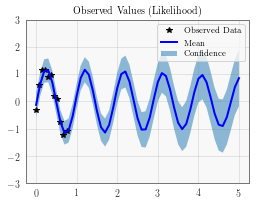

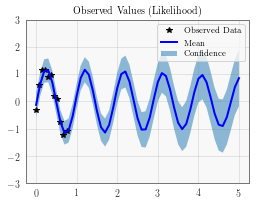

In [29]:
plot_model_and_predictions(posterior_model)